In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
print("TensorFlow version is ", tf.__version__)
# os.mkdir('tmp')
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O ./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  


TensorFlow version is  1.13.1


In [2]:
os.listdir('.')

['tmp',
 'Dogs_and_Cats.ipynb',
 'cats_and_dogs_filtered.zip',
 'TransferLearning-InceptionV3.ipynb',
 'data',
 'test',
 '.ipynb_checkpoints',
 'Function to divide dataset.ipynb',
 'Dogs_and_Cats-DataAugmentation.ipynb']

In [3]:
local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_v1[0][0]     
_____________________________________

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


Rebuilding top classifier and removing last_layer from pre_trained_model

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_dir = './data/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Originally:
* steps_per_epoch = 100
* epochs = 100
* validation_steps = 50

Testing here with just 5 epochs just to test script

In [7]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 5,
            validation_steps = 50,
            verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
50/50 [==============================] - 18s 357ms/step - loss: 0.8382 - acc: 0.8130
 - 98s - loss: 0.5157 - acc: 0.7645 - val_loss: 0.8382 - val_acc: 0.8130
Epoch 2/5
50/50 [==============================] - 17s 339ms/step - loss: 0.2497 - acc: 0.9290
 - 82s - loss: 0.3619 - acc: 0.8340 - val_loss: 0.2497 - val_acc: 0.9290
Epoch 3/5
50/50 [==============================] - 17s 344ms/step - loss: 0.3110 - acc: 0.9280
 - 82s - loss: 0.3557 - acc: 0.8485 - val_loss: 0.3110 - val_acc: 0.9280
Epoch 4/5
50/50 [==============================] - 17s 345ms/step - loss: 0.3320 - acc: 0.9340
 - 83s - loss: 0.3150 - acc: 0.8755 - val_loss: 0.3320 - val_acc: 0.9340
Epoch 5/5
50/50 [==============================] - 17s 349ms/step - loss: 0.2998 - acc: 0.9470
 - 83s - loss: 0.3322 - acc: 0.8630 - val_loss: 0.2998 - val_acc: 0.9470


In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 0 Axes>

### Reading generator filenames label to get a prediction accurate

In [9]:
print(train_generator.filenames)

['cats/cat.0.jpg', 'cats/cat.1.jpg', 'cats/cat.10.jpg', 'cats/cat.100.jpg', 'cats/cat.101.jpg', 'cats/cat.102.jpg', 'cats/cat.103.jpg', 'cats/cat.104.jpg', 'cats/cat.105.jpg', 'cats/cat.106.jpg', 'cats/cat.107.jpg', 'cats/cat.108.jpg', 'cats/cat.109.jpg', 'cats/cat.11.jpg', 'cats/cat.110.jpg', 'cats/cat.111.jpg', 'cats/cat.112.jpg', 'cats/cat.113.jpg', 'cats/cat.114.jpg', 'cats/cat.115.jpg', 'cats/cat.116.jpg', 'cats/cat.117.jpg', 'cats/cat.118.jpg', 'cats/cat.119.jpg', 'cats/cat.12.jpg', 'cats/cat.120.jpg', 'cats/cat.121.jpg', 'cats/cat.122.jpg', 'cats/cat.123.jpg', 'cats/cat.124.jpg', 'cats/cat.125.jpg', 'cats/cat.126.jpg', 'cats/cat.127.jpg', 'cats/cat.128.jpg', 'cats/cat.129.jpg', 'cats/cat.13.jpg', 'cats/cat.130.jpg', 'cats/cat.131.jpg', 'cats/cat.132.jpg', 'cats/cat.133.jpg', 'cats/cat.134.jpg', 'cats/cat.135.jpg', 'cats/cat.136.jpg', 'cats/cat.137.jpg', 'cats/cat.138.jpg', 'cats/cat.139.jpg', 'cats/cat.14.jpg', 'cats/cat.140.jpg', 'cats/cat.141.jpg', 'cats/cat.142.jpg', 'cats/ca

We get the **size of the training set** by interrogating generator.filenames method

In [10]:
print(len(train_generator.filenames))

2000


In [11]:
train_generator.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [12]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [13]:
validation_generator.class_indices

{'cats': 0, 'dogs': 1}

## Prediction
Let's try to upload an image and make a prediction with the model

**Super important**
**Do not forget to scale value!!!**

Using TensorFlow backend.


cat.1.jpg is a cat
[[1.6925052e-17]]


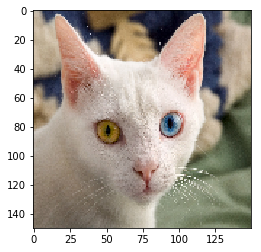

In [14]:
import numpy as np
from keras.preprocessing import image


def prediction(path_img):
    img = image.load_img(path_img, target_size=(150,150))
    x = image.img_to_array(img)
    x = x/255.
    x = np.expand_dims(x, axis=0)
    classes = model.predict(x)
    plt.imshow(img)
    if classes > 0.5:
        print(path_img.split('/')[-1]+' is a dog')
    else:
         print(path_img.split('/')[-1]+' is a cat')   
    return classes

y1 = prediction(path_img='./test/cats/cat.1.jpg')
print(y1)





dog.3.jpg is a dog
[[1.]]


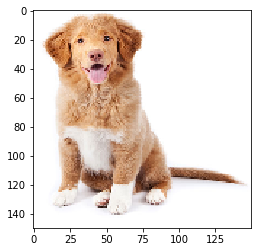

In [15]:
y2 = prediction(path_img='./test/dogs/dog.3.jpg')
print(y2)

## Confusion Matrix
Let us suppose that folder **test** is formed by the images we want to test our model, thus we need:
* get a label from predictions
* get a label from ground truth
Let us read the test dataset to create labels

In order to make predictions correctly on the test dataset it is necessary to generate the set without shuffle. In https://keras.io/preprocessing/image/ it can be seen that default state is **shuffle true**

In [16]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_base_dir = '.'

test_dir = os.path.join( test_base_dir, 'test')
os.listdir(test_dir)
# Note that the validation data should not be augmented!
test_datagen_2 = ImageDataGenerator( rescale = 1.0/255. )

# Flow validation images in batches of 20 using test_datagen generator
test_generator =  test_datagen_2.flow_from_directory( test_dir,
                                                      batch_size  = 1,
                                                      class_mode  = 'binary', 
                                                      target_size = (150, 150),
                                                      shuffle = False)

Found 10 images belonging to 2 classes.


In [17]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}

In [18]:
test_generator.filenames

['cats/cat.1.jpg',
 'cats/cat.2.jpg',
 'cats/cat.3.jpg',
 'cats/cat.4.jpg',
 'cats/cat.5.jpg',
 'dogs/dog.1.jpg',
 'dogs/dog.2.jpg',
 'dogs/dog.3.jpg',
 'dogs/dog.4.jpg',
 'dogs/dog.5.jpg']

Hope not to have a problem with *cat* vs *cats*. But we notice that both cat and cats are in class value 0

For prediction I am considering: https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator

For prediction we can get the classes and the probabilities

In [19]:
filenames = test_generator.filenames
nb_samples = len(filenames)
y_predict_prob = model.predict_generator(test_generator,steps = nb_samples)
# y_predict_class = model.predict_classes(test_generator, steps =nb_samples)
# print('class', y_predict_class)
print('prob', y_predict_prob)

prob [[1.6924665e-17]
 [2.0998268e-09]
 [1.6807937e-06]
 [3.2674097e-16]
 [2.9794231e-12]
 [1.0000000e+00]
 [9.9999988e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9999845e-01]]


In [20]:
# yypredict = model.predict(test_generator)
# np.round(yypredict, decimals=0)
predicted_class_indices = [1 if k>0.5 else 0 for k in y_predict_prob]
predicted_class_indices

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

Probably we need to ceil the numbers obtained 

In [21]:
# y_predict_rounded = np.round(y_predict, decimals=0)
# y_predict_rounded

In [22]:
import pandas as pd
df = pd.DataFrame(columns=['filename', 'class-true-value', 'class-pred-value', 'class-probability'])
df['filename'] = test_generator.filenames
df['class-true-value'] = test_generator.labels
df['class-pred-value'] = predicted_class_indices
df['class-probability'] = y_predict_prob
# test_generator.class_indices
df

,filename,class-true-value,class-pred-value,class-probability
0,cats/cat.1.jpg,0,0,1.692466e-17
1,cats/cat.2.jpg,0,0,2.099827e-09
2,cats/cat.3.jpg,0,0,1.680794e-06
3,cats/cat.4.jpg,0,0,3.267410e-16
4,cats/cat.5.jpg,0,0,2.979423e-12
5,dogs/dog.1.jpg,1,1,1.000000e+00
6,dogs/dog.2.jpg,1,1,9.999999e-01
7,dogs/dog.3.jpg,1,1,1.000000e+00
8,dogs/dog.4.jpg,1,1,1.000000e+00
9,dogs/dog.5.jpg,1,1,9.999985e-01


### Confusion Matrix

In [23]:
from sklearn.metrics  import confusion_matrix
# y_true = test_generator.labels
# y_pred = y_predict_rounded
cm = confusion_matrix(y_true=test_generator.labels, y_pred=predicted_class_indices)
cm

array([[5, 0],
       [0, 5]])

### Accuracy

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=test_generator.labels, y_pred=predicted_class_indices)

1.0

### Classification Report

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_generator.labels, y_pred=predicted_class_indices))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

   micro avg       1.00      1.00      1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



### Verification
Since I am not sure about the predictions stimated I am going to iterate on each image and create an array

In [26]:
# test = os.listdir('./test/')
print(test_dir)
y_pred_m = []
files=[]
for filename in os.listdir(test_dir):
    file = test_dir+'/'+filename
    for item in os.listdir(file):
        file2 = file+'/'+item
        if file2.split('.')[-1]=='jpg':
            files.append(file2)
files

./test


['./test/dogs/dog.5.jpg',
 './test/dogs/dog.2.jpg',
 './test/dogs/dog.3.jpg',
 './test/dogs/dog.4.jpg',
 './test/dogs/dog.1.jpg',
 './test/cats/cat.2.jpg',
 './test/cats/cat.1.jpg',
 './test/cats/cat.4.jpg',
 './test/cats/cat.5.jpg',
 './test/cats/cat.3.jpg']

dog.5.jpg is a dog
dog.2.jpg is a dog
dog.3.jpg is a dog
dog.4.jpg is a dog
dog.1.jpg is a dog
cat.2.jpg is a cat
cat.1.jpg is a cat
cat.4.jpg is a cat
cat.5.jpg is a cat
cat.3.jpg is a cat


array([[[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]]], dtype=float32)

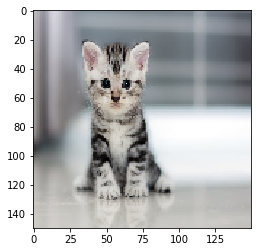

In [27]:
prediction_array = [prediction(img) for img in files]

np.round(prediction_array, decimals=0)